# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy import stats
from time import time

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, MinMaxScaler
#from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#from xgboost.sklearn import XGBRegressor
#import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
%%time
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 57 s, sys: 16.4 s, total: 1min 13s
Wall time: 12min 59s


In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [4]:
# Due the loading process takes its time
# Back up of data for future analysis with raw data
azdias_copy = azdias.copy()
customers_copy = customers.copy()

In [5]:
azdias = azdias_copy 
customers = customers_copy

### Exploratory Data Analysis

In [6]:
print('Number of rows and columns in the azdias dataset are: {} and {}'.format(azdias.shape[0],azdias.shape[1]))

Number of rows and columns in the azdias dataset are: 891221 and 366


In [7]:
azdias.sample(8)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
546266,237480,-1,8.0,18.0,NaN,NaN,NaN,NaN,18.0,8.0,...,4.0,7.0,8.0,5.0,4.0,4.0,7.0,5,2,1
680110,401630,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,3
202500,889391,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,3.0,...,3.0,9.0,12.0,9.0,5.0,9.0,2.0,4,2,3
105304,297682,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,9.0,...,3.0,6.0,7.0,4.0,6.0,9.0,4.0,3,2,4
110043,249889,-1,1.0,9.0,NaN,NaN,NaN,NaN,NaN,1.0,...,2.0,6.0,6.0,3.0,6.0,9.0,7.0,1,2,4
579218,393511,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,9.0,6.0,3.0,6.0,9.0,3.0,3,2,4
863617,203575,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,3
554381,790504,3,1.0,12.0,NaN,NaN,NaN,NaN,12.0,25.0,...,4.0,1.0,1.0,1.0,6.0,8.0,3.0,6,1,3


In [8]:
print('Number of rows and columns in the customers dataset are: {} and {}'.format(customers.shape[0],customers.shape[1]))

Number of rows and columns in the customers dataset are: 191652 and 369


In [9]:
customers.sample(8)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
97255,108294,1,1.0,12.0,NaN,NaN,NaN,NaN,12.0,1.0,...,6.0,3.0,9.0,4.0,3,FOOD,SINGLE_BUYER,1,1,4
9865,166508,-1,1.0,16.0,NaN,NaN,NaN,NaN,0.0,1.0,...,5.0,2.0,9.0,3.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
158432,88468,1,1.0,10.0,NaN,NaN,NaN,NaN,10.0,2.0,...,4.0,6.0,9.0,7.0,4,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
111718,114423,2,1.0,12.0,NaN,NaN,NaN,NaN,12.0,22.0,...,2.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,3
2188,81272,1,1.0,17.0,NaN,NaN,NaN,NaN,10.0,3.0,...,1.0,2.0,9.0,4.0,3,COSMETIC,MULTI_BUYER,0,1,4
55994,45803,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,6.0,9.0,2.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,2
40081,127513,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,FOOD,SINGLE_BUYER,0,2,1
95587,63325,2,2.0,9.0,NaN,NaN,NaN,NaN,9.0,3.0,...,3.0,4.0,9.0,3.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4


In [10]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [11]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [12]:
# Differences in columns
azdias_cols = set(azdias.columns)
customers_cols = set(customers.columns)
customers_cols - azdias_cols

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [13]:
print("Customers dataset has three columns more: {} ".format(customers_cols - azdias_cols))

Customers dataset has three columns more: {'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'} 


In [14]:
customers['PRODUCT_GROUP'].unique()

array(['COSMETIC_AND_FOOD', 'FOOD', 'COSMETIC'], dtype=object)

In [15]:
customers['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

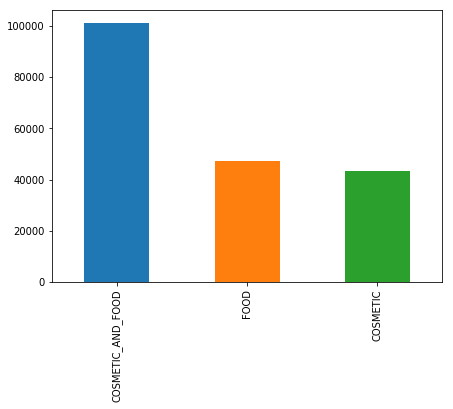

In [16]:
customers['PRODUCT_GROUP'].value_counts().plot(kind='bar', figsize=(7,5))

In [17]:
customers['CUSTOMER_GROUP'].unique()

array(['MULTI_BUYER', 'SINGLE_BUYER'], dtype=object)

In [18]:
customers['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

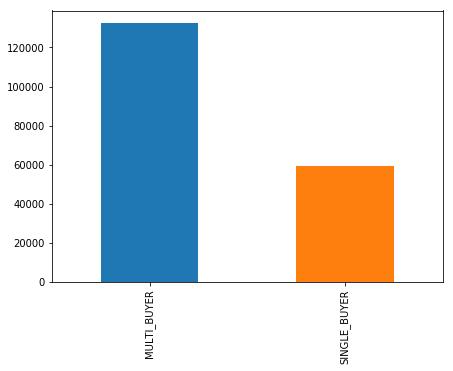

In [19]:
customers['CUSTOMER_GROUP'].value_counts().plot(kind='bar', figsize=(7,5))

In [20]:
customers['ONLINE_PURCHASE'].unique()

array([0, 1])

In [21]:
customers['ONLINE_PURCHASE'].value_counts()

0    174356
1     17296
Name: ONLINE_PURCHASE, dtype: int64

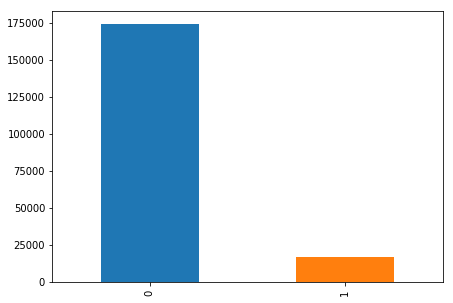

In [22]:
# Graph 
customers['ONLINE_PURCHASE'].value_counts().plot(kind='bar', figsize=(7,5))

The different columns are:
- PRODUCT_GROUP': Indicating the product group preferences of the client
- 'CUSTOMER_GROUP': Indicating the customer group the client is classified in
- 'ONLINE_PURCHASE': Indicating whether or not the customer made a purchase online

In [23]:
# Data types of azdias dataset
azdias.get_dtype_counts()

float64    267
int64       93
object       6
dtype: int64

In [24]:
azdias.select_dtypes(['object']).sample(8)

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
149902,2A,2,12,D19_SONSTIGE,1992-02-12 00:00:00,W
200929,9D,9,51,NaN,1992-02-10 00:00:00,W
612043,4D,4,24,D19_UNBEKANNT,1992-02-10 00:00:00,W
523677,7A,7,41,D19_VERSAND_REST,1992-02-12 00:00:00,W
62132,3D,3,25,D19_UNBEKANNT,1992-02-10 00:00:00,W
615714,2D,2,14,NaN,1992-02-12 00:00:00,W
583909,2D,2,14,D19_RATGEBER,1992-02-12 00:00:00,W
406818,1A,1,13,D19_VERSICHERUNGEN,1993-11-03 00:00:00,W


In [25]:
# Data types of customers dataset
customers.get_dtype_counts()

float64    267
int64       94
object       8
dtype: int64

In [26]:
customers.select_dtypes(['object']).sample(8)

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
164094,NaN,NaN,NaN,NaN,NaN,NaN,COSMETIC_AND_FOOD,MULTI_BUYER
15426,8A,8,51,D19_VOLLSORTIMENT,1992-02-12 00:00:00,W,FOOD,SINGLE_BUYER
126145,NaN,NaN,NaN,D19_BEKLEIDUNG_GEH,NaN,NaN,COSMETIC,MULTI_BUYER
86474,1C,1,14,D19_WEIN_FEINKOST,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
103107,7A,7,41,D19_WEIN_FEINKOST,1995-08-03 00:00:00,W,COSMETIC,MULTI_BUYER
90254,3D,3,25,D19_DROGERIEARTIKEL,1992-02-10 00:00:00,W,COSMETIC,SINGLE_BUYER
42089,6E,6,45,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
168492,7A,7,41,D19_BEKLEIDUNG_REST,1992-02-12 00:00:00,W,COSMETIC,MULTI_BUYER


In [27]:
customers['ONLINE_PURCHASE'].sample(8)

179571    0
167640    0
147112    0
143437    0
66642     0
112371    0
144001    0
14181     0
Name: ONLINE_PURCHASE, dtype: int64

Azdias dataframe has six categorical columns, one of those columns is a date column (EINGEFUEGT_AM). In the same way, Customers dataset has two more categorical columns which are not in the Azdias dataset.

In [28]:
customers['PRODUCT_GROUP'].unique()

array(['COSMETIC_AND_FOOD', 'FOOD', 'COSMETIC'], dtype=object)

In [29]:
# Missing values
azdias_missing = azdias.isnull().sum().sort_values(ascending = False)
azdias_missing_pct = (azdias_missing / len(azdias)) * 100 

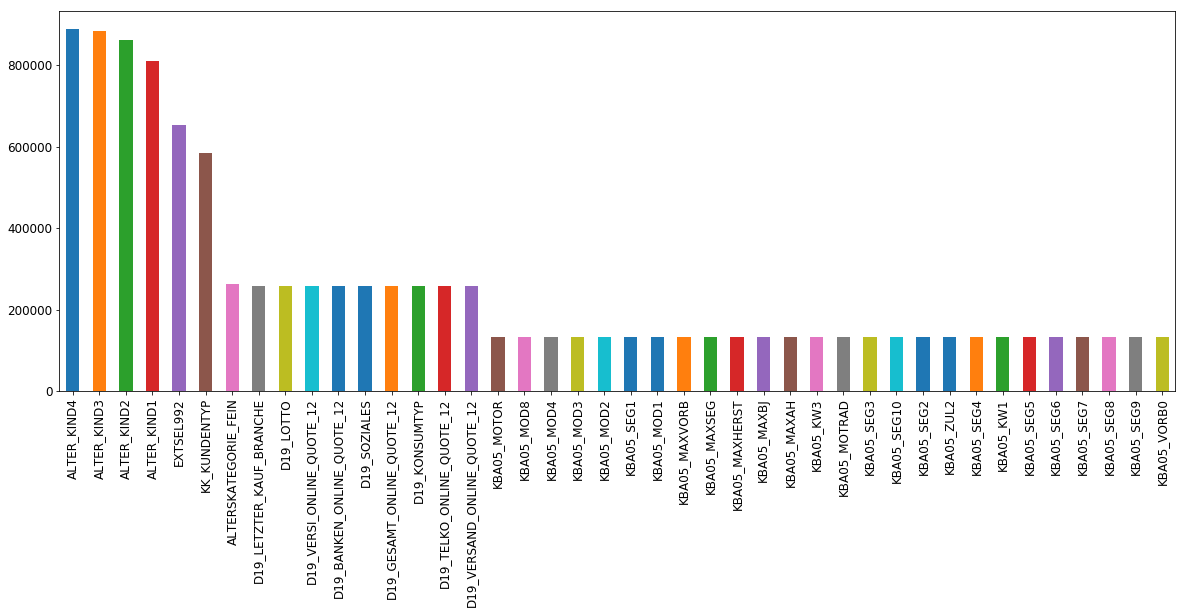

In [30]:
# Graph of missing data
azdias_missing[:42].plot(kind='bar', figsize=(20,7), fontsize=12)

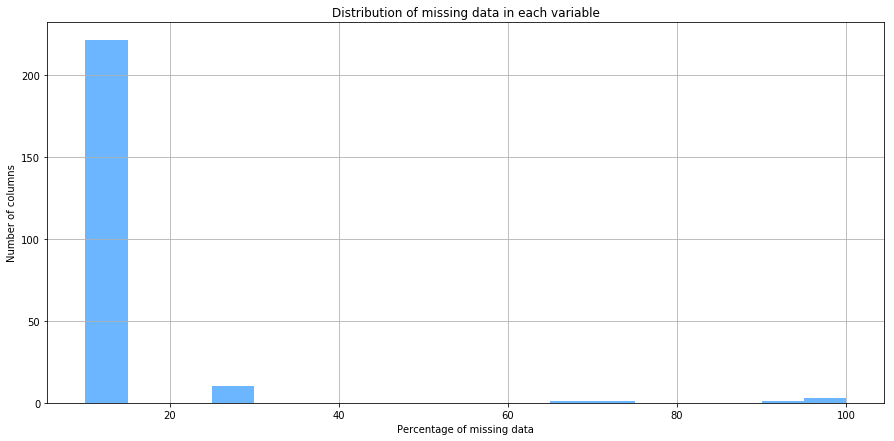

In [31]:
# Dsitribution of missing data
plt.figure(figsize=(15,7))
plt.hist(azdias_missing_pct, bins=np.linspace(10,100,19), alpha=0.65, facecolor='dodgerblue')

plt.xlabel('Percentage of missing data')
plt.ylabel('Number of columns')
plt.title('Distribution of missing data in each variable')
plt.grid(True)

plt.show()

In [32]:
# Missing values percentage
print('Percentage of missing values per column')
azdias_missing_pct

Percentage of missing values per column


ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_LOTTO                      28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
KBA05_MOTOR                    14.959701
KBA05_MOD8                     14.959701
KBA05_MOD4                     14.959701
KBA05_MOD3                     14.959701
KBA05_MOD2                     14.959701
KBA05_SEG1                     14.959701
KBA05_MOD1                     14.959701
KBA05_MAXVORB                  14.959701
KBA05_MAXSEG    

In [33]:
na_variables = azdias.isnull().mean()

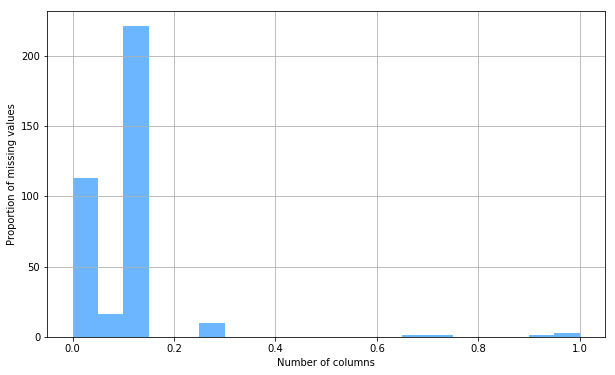

In [34]:
# Distribution of nan values
plt.figure(figsize=(10,6))
plt.hist(na_variables, bins=np.arange(0,1+0.05, 0.05), alpha=0.65, facecolor='dodgerblue')
plt.xlabel('Number of columns')
plt.ylabel('Proportion of missing values')
plt.grid(True);

In [35]:
value = 0
for x in range(11):
    print(f'Columns having  missing values > {value}%: ',len(azdias_missing_pct[azdias_missing_pct>value].index))
    value = value + 10

Columns having  missing values > 0%:  273
Columns having  missing values > 10%:  237
Columns having  missing values > 20%:  16
Columns having  missing values > 30%:  6
Columns having  missing values > 40%:  6
Columns having  missing values > 50%:  6
Columns having  missing values > 60%:  6
Columns having  missing values > 70%:  5
Columns having  missing values > 80%:  4
Columns having  missing values > 90%:  4
Columns having  missing values > 100%:  0


In [36]:
azdias_null_rows = azdias.isnull().sum(axis=1)

In [37]:
azdias_null_rows.describe()

count    891221.000000
mean         37.580940
std          75.290108
min           0.000000
25%           5.000000
50%           6.000000
75%          16.000000
max         259.000000
dtype: float64

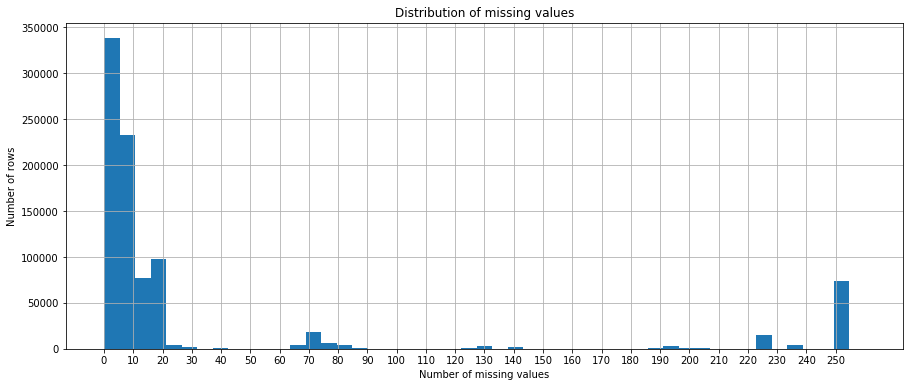

In [38]:
# Plotting distribution of missing values
plt.figure(figsize=(15,6))
plt.hist(azdias_null_rows, bins=np.linspace(min(azdias_null_rows), max(azdias_null_rows)+1))

plt.xticks(np.arange(min(azdias_null_rows), max(azdias_null_rows)+1, 10))
plt.ylabel('Number of rows')
plt.xlabel('Number of missing values')
plt.title('Distribution of missing values')
plt.grid(True);

In [39]:
x = (azdias_null_rows.value_counts().sort_index().cumsum()/len(azdias))*100

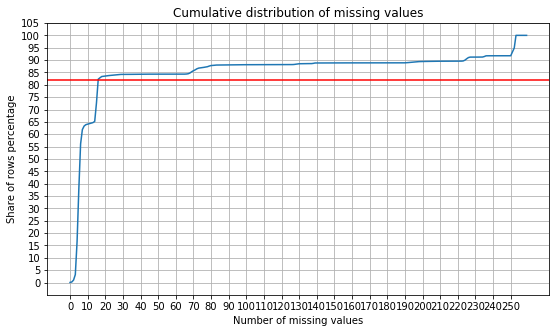

In [40]:
plt.figure(figsize=(9,5))
plt.plot(x)
plt.axhline(y=82, color='r', linestyle='-')

plt.yticks(np.arange(0, 110, 5))
plt.xticks(np.arange(min(x.index), max(x.index)+1, 10))
plt.ylabel('Share of rows percentage')
plt.xlabel('Number of missing values')
plt.title('Cumulative distribution of missing values')
plt.grid(True);

In [41]:
x.iloc[15:31]

15    72.662336
16    82.272186
17    82.839498
18    83.348126
19    83.452589
20    83.515200
21    83.628752
22    83.731420
23    83.807271
24    83.888957
25    83.976702
26    84.033814
27    84.070057
28    84.145234
29    84.207733
30    84.219739
dtype: float64

About 82% of the rows contain 16 or fewer empty rows. Looking at the horizontal line that is drawn in the graph above shows that deleting rows that have 16 or more missing values results in at least 18% of the information being lost. 

### Data Preprocessing

In [42]:
%%script echo skipping
azdias = azdias[azdias.isnull().sum(axis=1) <= 16].reset_index(drop=True)

skipping


In [43]:
%%script echo skipping
print('The new number of rows and columns in the azdias dataset are: {} and {}'.format(azdias.shape[0],azdias.shape[1]))

skipping


According to the following analysis, 6 columns have more than 65% of the missing information, so we will proceed to eliminate these columns

In [44]:
%%script echo skipping
drop_columns = azdias.columns[na_variables > 0.65]

skipping


In [45]:
%%script echo skipping
print('The columns to drop are: ', drop_columns)

skipping


In [46]:
%%script echo skipping
# Drop the extra column of customers dataset
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

skipping


In [47]:
%%script echo skipping
customers.shape

skipping


In [48]:
%%script echo skipping
# Dropping 6 columns
azdias = azdias.drop(drop_columns,axis=1)
customers = customers.drop(drop_columns,axis=1)

skipping


In [49]:
%%script echo skipping
# Variable EINGEFUEGT_AM has too many different items

azdias = azdias.drop(['EINGEFUEGT_AM'],axis=1)
customers = customers.drop(['EINGEFUEGT_AM'],axis=1)

skipping


In [50]:
%%script echo skipping
# Variable D19_LETZTER_KAUF_BRANCHE has many different items

azdias = azdias.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)
customers = customers.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)

skipping


In [51]:
%%script echo skipping
print('The new number of rows and columns in the azdias dataset are: {} and {}'.format(azdias.shape[0],azdias.shape[1]))

skipping


In [52]:
%%script echo skipping
print('The new number of rows and columns in the customers dataset are: {} and {}'.format(customers.shape[0],customers.shape[1]))

skipping


In [53]:
%%script echo skipping
# Through the analysis of highly correlated variables, the size of the dataframe is reduced

# 1. Correlation Matrix
# azdias
corr_matrix = azdias.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# 2. Columns to drop based on threshold limit
# azdias
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]

# 3. Dropping columns from azdias dataset
# azdias
azdias = azdias.drop(drop_columns, axis=1)
print('Number of columns of azdias dataset', len(azdias.columns))


# 1. Correlation Matrix
# customers
corr_matrix = customers.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# 2. Columns to drop based on threshold limit
# customers
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]

# 3. Dropping columns from customers dataset
# customers
customers = customers.drop(drop_columns, axis=1)
print('Number of columns of customers dataset', len(customers.columns))

skipping


In [54]:
%%script echo skipping
print('The new number of rows and columns in the azdias dataset are: {} and {}'.format(azdias.shape[0],azdias.shape[1]))

skipping


In [55]:
%%script echo skipping
print('The new number of rows and columns in the customers dataset are: {} and {}'.format(customers.shape[0],customers.shape[1]))

skipping


In [56]:
%%script echo skipping
# Exploring variables with object data type
azdias.select_dtypes(include=['object']).sample(8)

skipping


In [57]:
%%script echo skipping
customers.select_dtypes(include=['object']).sample(8)

skipping


In [58]:
%%script echo skipping
#  Finding categorical fields
cols = azdias.columns
num_cols = azdias._get_numeric_data().columns
print('Number of columns: ',num_cols)
print('Categorical variables: ',list(set(cols) - set(num_cols)))

skipping


In [59]:
%%script echo skipping
# Imputing missing values with -1 indicating unknown as in the description
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)

azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)

azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)

azdias[['CAMEO_DEU_2015','OST_WEST_KZ']]=azdias[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)
customers[['CAMEO_DEU_2015','OST_WEST_KZ']]=customers[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)

skipping


In [60]:
%%script echo skipping
azdias.isnull().sum().sort_values(ascending=False).head(15)

skipping


In [61]:
%%script echo skipping
customers.isnull().sum().sort_values(ascending=False).head(15)

skipping


In [62]:
%%script echo skipping
# Using fillna with 9 for fields that has 9 marked as unknown
azdias[azdias.columns[(azdias==9).any()]] = azdias[azdias.columns[(azdias==9).any()]].fillna(9)
customers[customers.columns[(customers==9).any()]] = customers[customers.columns[(customers==9).any()]].fillna(9)

skipping


In [63]:
%%script echo skipping
# Using fillna with 0 for fields that has 0 marked as unknown
azdias[azdias.columns[(azdias==0).any()]] = azdias[azdias.columns[(azdias==0).any()]].fillna(0)
customers[customers.columns[(customers==0).any()]] = customers[customers.columns[(customers==0).any()]].fillna(0)

skipping


In [64]:
%%script echo skipping
# Using fillna with -1 for fields that has 0 marked as unknown
azdias[azdias.columns[(azdias==-1).any()]] = azdias[azdias.columns[(azdias==-1).any()]].fillna(-1)
customers[customers.columns[(customers==-1).any()]] = customers[customers.columns[(customers==-1).any()]].fillna(-1)

skipping


In [65]:
%%script echo skipping
# One Hot Encoding for categorical variables
azdias = pd.get_dummies(azdias)
customers = pd.get_dummies(customers)

skipping


In [66]:
%%script echo skipping
azdias.columns

skipping


In [67]:
%%script echo skipping
customers.columns

skipping


In [68]:
%%script echo skipping
azdias_columns = azdias.columns
customers_columns = customers.columns

skipping


In [69]:
%%script echo skipping
print('The new number of rows and columns in the azdias dataset are: {} and {}'.format(azdias.shape[0],azdias.shape[1]))

skipping


In [70]:
%%script echo skipping
print('The new number of rows and columns in the customers dataset are: {} and {}'.format(customers.shape[0],customers.shape[1]))

skipping


In [71]:
%%script echo skipping
# Imputing missing values with mode through the sklearn method
imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)

azdias = imputer.fit_transform(azdias)
azdias = pd.DataFrame(azdias)
print('imputed azdias: ', azdias.head(5))

customers = imputer.fit_transform(customers)
customers = pd.DataFrame(customers)
print('imputed customers: ', customers.head(5))

skipping


In [72]:
%%script echo skipping
# Converting to int
azdias = azdias.astype(int)
customers = customers.astype(int)

skipping


### Outliers detection and removal

In [73]:
%%script echo skipping
# Detect and exclude outliers in a pandas DataFrame
azdias = azdias[(np.abs(stats.zscore(azdias)) < 6).all(axis=1)]
customers = customers[(np.abs(stats.zscore(customers)) < 6).all(axis=1)]

skipping


In [74]:
%%script echo skipping
print('The new number of rows and columns in the azdias dataset are: {} and {}'.format(azdias.shape[0],azdias.shape[1]))

skipping


In [75]:
%%script echo skipping
print('The new number of rows and columns in the customers dataset are: {} and {}'.format(customers.shape[0],customers.shape[1]))

skipping


In [76]:
%%script echo skipping
# Checking missing values
azdias.isnull().any().sum()
customers.isnull().any().sum()

skipping


In [77]:
#azdias.to_pickle('azdias_before_scaling')
#customers.to_pickle('customers_before_scaling')

### Data standardization 

In [78]:
%%script echo skipping
# Feature scaling
scale = StandardScaler(copy=False)
azdias[azdias.columns] = scale.fit_transform(azdias)

skipping


In [79]:
%%script echo skipping
np.size((azdias_columns == azdias_columns))-np.sum((azdias_columns == azdias_columns))

skipping


In [80]:
%%script echo skipping
customers[customers.columns] = scale.fit_transform(customers)

skipping


In [81]:
#azdias.to_pickle('azdias_scaled')
#customers.to_pickle('customers_scaled')

In [82]:
%%script echo skipping
azdias_columns

skipping


### Implementation

Previously different analyses have been performed on the data sets in question, however, these analyses will now be encapsulated in a single function which cleans and organizes the data.

In [83]:
def data_preprocess(df, for_clustering, df_name=None):
    """Function to processing of the data in order to have it ready for segmentation

    Parameters:
    df: Dataframe to which processing will be performed 
    for_clustering: True if dataframe is for clustering
    df_name: Dataframe name 

    Returns:
    df: Dataframe with preprocessing applied

   """
    
    if for_clustering:
        if df_name == 'azdias':
            df = df[df.isnull().sum(axis=1) <= 16].reset_index(drop=True)
        elif df_name == 'customers':            
            df.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
        
    drop_cols = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP']
    
    df = df.drop(drop_cols,axis=1)
    df = df.drop(['EINGEFUEGT_AM'],axis=1)
    df = df.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)

    # Correlation Matrix    
    corr_matrix = df.corr().abs()
    upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Columns to drop based on threshold limit
    drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
    # Dropping columns from customers dataset
    df = df.drop(drop_columns, axis=1)
    print('Shape of dataframe after correlation analysis', df.shape)


    # Imputing missing values with -1 indicating unknown as in the description
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
    df[['CAMEO_DEU_2015','OST_WEST_KZ']]=df[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)


    # Using fillna with 9 for fields that has 9 marked as unknown
    df[df.columns[(df==9).any()]] = df[df.columns[(df==9).any()]].fillna(9)
    # Using fillna with 0 for fields that has 0 marked as unknown
    df[df.columns[(df==0).any()]] = df[df.columns[(df==0).any()]].fillna(0)
    # Using fillna with -1 for fields that has 0 marked as unknown
    df[df.columns[(df==-1).any()]] = df[df.columns[(df==-1).any()]].fillna(-1)


    # One Hot Encoding for categorical variables
    df = pd.get_dummies(df)
    print('Shape of dataframe after One Hot Encoding', df.shape)
    
    df_columns = list(df.columns.values)

    # Imputing missing values with mode through the sklearn method
    imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df)
    print('Shape of dataframe after impute', df.shape)
    
    # Convert dataframe to int
    df = df.astype(int)

    # Detect and exclude outliers in a pandas DataFrame
    if for_clustering:
        print('Inside outliers if')
        df = df[(np.abs(stats.zscore(df)) < 6).all(axis=1)] 
        print('Shape of dataframe before scaling', df.shape)
    
    # Feature scaling
    scale = StandardScaler(copy=False)
    scaled = scale.fit_transform(df)
    df = pd.DataFrame(scaled,columns= df_columns)
    print('Shape of dataframe after scaling', df.shape)
    
    # else:
    # df.columns = df_columns
        
    df = df.set_index('LNR')
    return df

### azdias dataframe processed

In [84]:
%%time
azdias = data_preprocess(azdias, True, 'azdias')

Shape of dataframe after correlation analysis (733227, 238)
Shape of dataframe after One Hot Encoding (733227, 284)
Shape of dataframe after impute (733227, 284)
Inside outliers if
Shape of dataframe before scaling (415405, 284)
Shape of dataframe after scaling (415405, 284)
CPU times: user 4min 45s, sys: 1min 22s, total: 6min 7s
Wall time: 50min 45s


In [85]:
print('The number of rows and columns in the azdias dataset are: {} and {}'.format(azdias.shape[0],azdias.shape[1]))

The number of rows and columns in the azdias dataset are: 415405 and 283


In [86]:
print(azdias.head(8))

           AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
LNR                                                               
 1.044527 -0.549413    1.155132  0.831893              0.911269   
 1.044589 -0.549413   -1.017213  1.223909              0.285868   
 1.044600  2.747309   -1.017213 -0.082810             -0.547999   
 1.044616 -0.549413    1.155132 -1.389529             -0.756466   
 1.044666 -0.549413   -1.017213  0.439878              0.285868   
 0.016048  0.274768   -1.017213 -0.082810             -0.547999   
-0.110411 -0.549413   -1.017213  1.093237              1.328203   
-0.110365 -0.549413    1.155132 -1.389529             -0.756466   

           ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
LNR                                                                      
 1.044527             0.170790     -0.142864   -0.281792     -0.610158   
 1.044589            -0.488492     -0.142864   -0.281792      2.240974   
 1.044600            -0.300126   

### customers dataframe processed

In [87]:
%%time
customers = data_preprocess(customers, True, 'customers')

Shape of dataframe after correlation analysis (191652, 256)
Shape of dataframe after One Hot Encoding (191652, 303)
Shape of dataframe after impute (191652, 303)
Inside outliers if
Shape of dataframe before scaling (100341, 303)
Shape of dataframe after scaling (100341, 303)
CPU times: user 1min 29s, sys: 7.14 s, total: 1min 36s
Wall time: 4min 16s


In [88]:
print('The number of rows and columns in the customers dataset are: {} and {}'.format(customers.shape[0],customers.shape[1]))

The number of rows and columns in the customers dataset are: 100341 and 302


In [89]:
print(customers.head(8))

           AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
LNR                                                               
-1.556361 -0.738505    1.010105  0.168897             -0.209002   
 0.872952  0.777112   -1.037635 -0.468300             -0.545546   
 0.873622  0.777112   -1.037635 -0.043502             -0.209002   
 0.118344  0.777112   -1.037635  2.080488              1.137176   
 0.118561  0.777112   -1.037635 -0.043502              0.127543   
 0.119321 -0.738505   -1.037635  2.292887              1.473721   
 0.119375 -0.738505   -1.037635  1.018493              1.473721   
 0.265013  1.534920   -0.013765  1.443291              0.800632   

           ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
LNR                                                                      
-1.556361             0.808794      0.992832   -0.193253     -0.686881   
 0.872952            -1.330334      0.992832   -0.193253     -1.545501   
 0.873622            -1.092653   

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Dimensionality reduction - Principal component analysis (PCA)

The cleaned and transformed Azdias dataset has 283 different features. The feature range can be reduced by applying PCA or Principal component analysis (PCA). According to The Royal Society Publishing is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss.

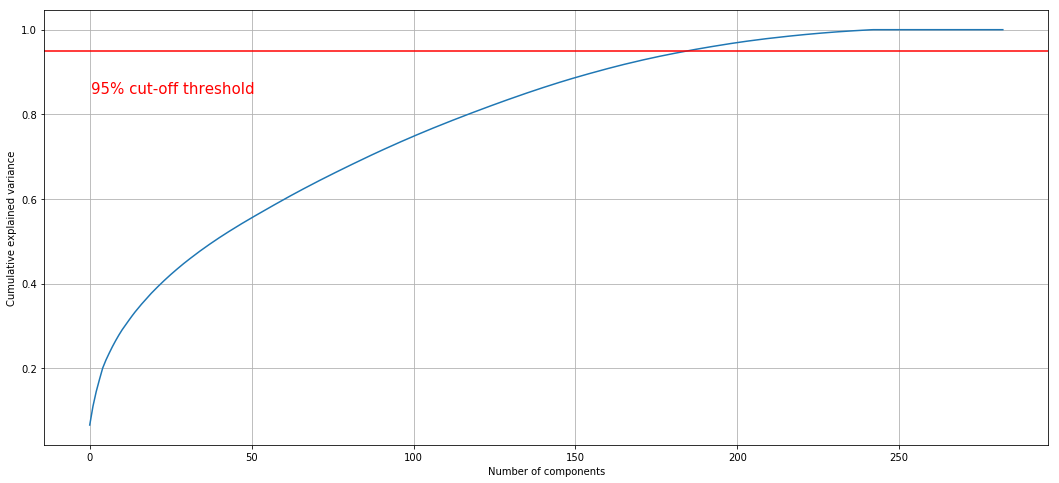

In [90]:
# Reducing the dimensionality of azdias dataset
pca = PCA().fit(azdias)
plt.figure(figsize=(18,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=15)
plt.grid(True)
plt.show()

In [91]:
cum_variance = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_), columns=['cumulative_variance'])
cum_variance.set_index(cum_variance.index+1, inplace=True)

In [92]:
num_components = cum_variance[cum_variance['cumulative_variance']>.95].index[0]
print('{} components explain 95% of variance in the dataset.'.format(num_components))

186 components explain 95% of variance in the dataset.


Of the close to 300 features in the dataset there are 186 that explain 95% of the variance. The dataset can be reduced to almost 66% approximately of its feature range while only losing 5% of variance.
In the same way, with PCA we want to make our data has high variance but we do not lose critical information from dataset while reducing dimensions.

So we are going to leave a larger number of variables, i.e. a total of 220 variables remaining.

In [93]:
def reduced_dataframe(df,n=220):
    """Function to reduced dataframe size through PCA function

    Parameters:
    df (dataframe): Pandas dataframe
    n (int): Number of components to keep

    Returns:
    reduced_data: Returning a Pandas dataframe with dimension reduction

   """
    pca = PCA(n_components=n).fit(df)
    reduced_data = pca.transform(df)
    reduced_data = pd.DataFrame(reduced_data)
    print(pca.explained_variance_ratio_.sum())
    return reduced_data

In [94]:
reduced_azdias = reduced_dataframe(azdias)
reduced_customers = reduced_dataframe(customers)

0.987001744003
0.997358386706


In [95]:
print('The number of rows and columns in the azdias dataset are: {} and {}'.format(reduced_azdias.shape[0],reduced_azdias.shape[1]))

The number of rows and columns in the azdias dataset are: 415405 and 220


In [96]:
reduced_azdias.head(8)

,0,1,2,3,4,5,6,7,8,9,...,210,211,212,213,214,215,216,217,218,219
0,2.703529,-1.869862,0.234048,0.154811,2.839287,-3.498354,1.952374,-2.058383,0.264975,-3.260718,...,0.165733,-0.290004,0.668892,-0.012892,-0.115964,0.782114,-0.394768,-0.622937,0.401396,0.455088
1,2.699462,-0.659331,3.574167,6.091062,-2.722294,-1.430668,-4.725703,-1.651532,-3.282229,-1.046125,...,0.438890,0.233816,-0.005865,-0.805070,-0.165274,0.203340,0.274022,-0.462720,-0.120820,-0.466787
2,2.707202,-2.135665,-0.741123,-1.438278,2.230685,0.381599,-0.569303,0.063301,-0.880403,-0.937020,...,0.825634,0.137735,-0.051073,-0.228571,-0.747726,-0.194313,1.059833,0.261754,0.351282,0.628428
3,-1.102197,1.053822,1.677138,-4.591045,-1.175285,-3.472136,0.982781,-0.131532,1.124514,-1.037131,...,1.057576,-0.115895,-0.157873,-0.125420,0.692968,0.481435,-0.125974,0.547159,-0.071598,0.199324
4,3.538814,-2.874705,-1.118186,-0.881512,2.690290,-1.598570,-1.683284,4.636161,0.355697,-3.284052,...,0.168599,-0.376426,-0.318966,0.177379,0.082538,-0.419281,0.587223,0.557984,0.320383,-0.115744
5,-4.636283,2.885804,-1.914048,-1.102132,-3.974792,-0.083083,0.756133,-1.523639,-2.804409,-4.017885,...,0.281354,0.254290,0.339954,0.158268,-0.810570,-0.579782,0.212908,-0.451324,-0.312956,0.063408
6,3.075689,0.915885,5.039853,-2.936347,-0.223363,-0.106600,-1.202533,-2.265801,-0.039178,0.412664,...,0.017311,0.626374,-0.564916,-0.407529,-0.202417,-0.195165,0.328316,0.645106,-0.092232,0.279167
7,1.355196,-1.306062,2.630764,-5.217800,1.024475,-1.548007,1.032004,-0.170584,1.678625,0.763128,...,0.372664,-0.958086,-0.387446,-0.395049,0.141605,0.526328,0.093576,-0.566299,0.417910,-0.450426


In [97]:
print('The number of rows and columns in the customers dataset are: {} and {}'.format(reduced_customers.shape[0],reduced_customers.shape[1]))

The number of rows and columns in the customers dataset are: 100341 and 220


In [98]:
reduced_customers.head(8)

,0,1,2,3,4,5,6,7,8,9,...,210,211,212,213,214,215,216,217,218,219
0,-8.181604,0.694115,1.677993,0.362250,-1.687850,-1.104060,1.141230,0.255567,-0.651574,0.659817,...,-0.441827,0.338404,0.205419,0.001483,0.048396,-0.055585,-0.039930,-0.002959,-0.004557,-0.004019
1,9.033657,0.816309,-1.458874,-3.485520,-1.770163,3.204296,-3.097571,1.503054,-3.426780,3.040414,...,-0.715008,0.806506,0.103205,0.237529,0.345069,0.469307,1.144985,-0.161149,-0.138420,-0.098574
2,10.258838,-6.335922,0.955381,-2.415843,-4.576069,1.143129,-1.803697,0.894611,-0.844607,-0.378673,...,0.357946,-0.167043,0.072852,0.573523,-0.016163,-0.014044,-0.156393,-0.092519,0.351774,-0.130125
3,12.154975,-1.800788,8.747283,2.581728,-0.098979,-1.315677,-0.624133,1.392404,2.239163,-1.547592,...,-0.250264,0.164489,0.242880,-0.117307,-0.345049,0.855396,-0.101679,0.486674,-0.052985,0.058044
4,10.531243,2.911606,2.264155,-0.428285,-0.254667,-0.660607,-1.772180,-0.903003,-1.635396,-1.070725,...,-0.046532,0.200544,-0.220023,-0.138808,0.243741,-0.061238,0.120138,0.117874,0.253480,-0.574901
5,10.773221,6.770362,2.378288,-5.727832,2.563020,-1.876543,-1.096232,1.409062,0.722937,-2.489275,...,0.081292,-0.154457,0.299854,-0.350455,-0.090587,0.140066,0.020808,-0.122277,-0.089637,0.337984
6,1.809180,4.438844,6.596015,2.192139,4.537154,-2.930931,0.450888,2.892556,-3.347173,1.077494,...,0.260482,0.452040,-0.024008,-0.077405,0.000957,0.204925,-0.592532,-0.008149,-0.129058,0.033518
7,10.419246,-2.120546,2.143846,2.506598,-1.855386,-3.770007,-4.459892,1.675043,-0.733199,0.496655,...,0.871658,0.178510,0.084223,0.203760,-0.013012,0.050485,-0.269310,-0.363253,-0.228080,0.233485


In [99]:
#reduced_azdias.to_pickle('reduced_azdias.p')
#reduced_customers.to_pickle('reduced_customers.p')

### K-means Clustering

According to the literature, K-means is an unsupervised classification (clustering) algorithm that groups objects into k groups based on their characteristics. The clustering is performed by minimizing the sum of distances between each object and the centroid of its group or cluster. The quadratic distance is usually used. 

In [100]:
def score(data, k):
    """Function to score a dataframe 

    Parameters:
    data (dataframe): Pandas dataframe
    k (int): Number of clusters

    Returns:
    float: The absolute value of the Opposite of the value of X on the K-means objective

   """
    kmeans_k = KMeans(k)
    model_k = kmeans_k.fit(data)
    return abs(model_k.score(data))

In [101]:
centers = np.linspace(1,21,21)
centers

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.])

In [102]:
# Elbow method
scores = []
for i in range(1, 21):
    scores.append(score(reduced_azdias.sample(20000), i))

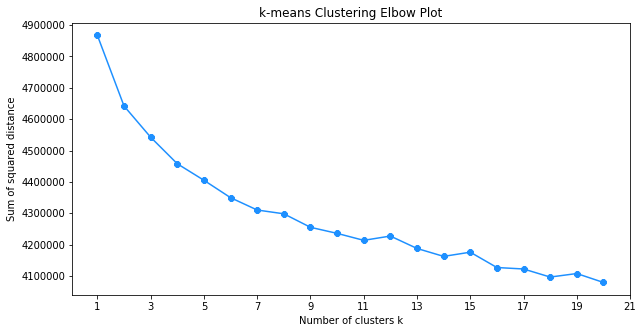

In [103]:
# Elbow graph
centers = np.linspace(1,20,20)

plt.figure(figsize=(10, 5))
plt.plot(centers, scores, linestyle='-', marker='8', color='dodgerblue')
plt.title('k-means Clustering Elbow Plot')
plt.xlabel("Number of clusters k")
plt.ylabel("Sum of squared distance")
plt.xticks(list(range(1,22,2)));

The inertia or sum of squared distances drops significantly until around 8 or 9 clusters and then primarily flattens out with a few further drops at 14, 20, 23, ... clusters. At 13, inertia increases a bit so 12 clusters are chosen as final number.

In [104]:
# Set K-means parameters
kmeans_clusters = 12

In [105]:
%%time
k_means = KMeans(kmeans_clusters)
model_kmeans = k_means.fit(reduced_azdias)
prediction_azdias = model_kmeans.predict(reduced_azdias)

CPU times: user 6min 40s, sys: 11.4 s, total: 6min 51s
Wall time: 7min


In [106]:
azdias_clustered = pd.DataFrame(prediction_azdias, columns=['Cluster'])

In [107]:
prediction_customers = model_kmeans.predict(reduced_customers)

In [108]:
customers_clustered = pd.DataFrame(prediction_customers, columns=['Cluster'])

### Clustered datasets analysis

In [109]:
# Count number of predictions for each customer segment
customers_clusters = pd.Series(prediction_customers)
cust_clus = customers_clusters.value_counts().sort_index()

In [110]:
# Count number in each population segment
population_clusters = pd.Series(prediction_azdias)
popul_clus = population_clusters.value_counts().sort_index()

In [111]:
# Create a dataframe from population and customer segments
df_statistics = pd.concat([popul_clus, cust_clus], axis=1).reset_index()
df_statistics.columns = ['cluster','population','customer']

df_statistics['difference'] = (df_statistics['customer']/df_statistics['customer'].sum()*100) - (df_statistics['population']/df_statistics['population'].sum()*100)

In [112]:
df_statistics.sample(12) 

,cluster,population,customer,difference
3,3,34688,65,-8.285626
5,5,48354,460,-11.181770
10,10,43437,13668,3.165008
2,2,34536,707,-7.609217
9,9,26179,1018,-5.287502
4,4,12959,5243,2.105576
7,7,31754,46443,38.641061
8,8,35720,7641,-0.983805
0,0,30203,159,-7.112276
6,6,43610,2635,-7.872143


Comparing the proportion of data in each cluster for the customer dataset to the proportion of data in each cluster for the general population.

In [113]:
df_statistics['pop_percent'] = (df_statistics['population']/df_statistics['population'].sum()*100).round(2)
df_statistics['cust_percent'] = (df_statistics['customer']/df_statistics['customer'].sum()*100).round(2)

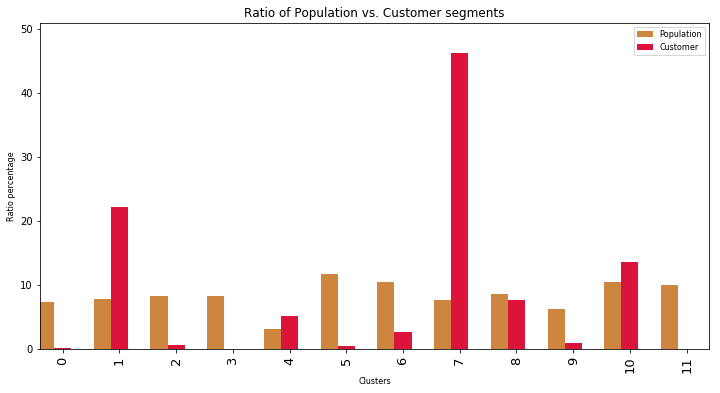

In [114]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(111)
ax = df_statistics['pop_percent'].plot(x=df_statistics['cluster'],width=-0.3,align='edge',color='peru',kind='bar',position=0)
ax = df_statistics['cust_percent'].plot(kind='bar',color='crimson',width = 0.3, align='edge',position=1)
ax.set_xlabel('Clusters', fontsize=8) 
ax.set_ylabel('Ratio percentage', fontsize=8)
ax.xaxis.set(ticklabels=range(20))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('Population', 'Customer'),fontsize=8)
plt.title(('Ratio of Population vs. Customer segments'))
plt.show()

The plot shows how clusters are distributed across both datasets. Clusters are equally spread across the general population and show only small differences in size. This can be expected from dataset that represents the general population very well.

In contrast, the customers dataset exhibits a large imbalance across clusters. Cluster 5 and 6 stand out specifically: More than 50% of customers are mapped to these two clusters.

In [115]:
# Get cluster sizes in each dataset
population_clusters = azdias_clustered['Cluster'].value_counts().sort_index()
customer_clusters = customers_clustered['Cluster'].value_counts().sort_index()

In [116]:
# Concat both dataframes to one
clusters = pd.concat([population_clusters, customer_clusters], axis=1).reset_index()
clusters.columns = ['cluster', 'population_count', 'customers_count']
clusters['cluster']+=1

In [117]:
# Calculate share of each cluster
clusters['population_share'] = clusters['population_count']/clusters['population_count'].sum()*100
clusters['customers_share'] = clusters['customers_count']/clusters['customers_count'].sum()*100
clusters['diff_share'] = clusters['customers_share'] - clusters['population_share']

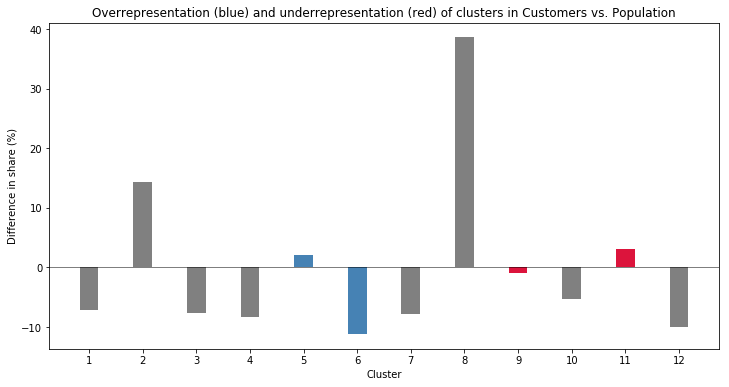

In [118]:
# Plot cluster differences
fig, ax = plt.subplots(figsize=(12,6))

ind = np.arange(kmeans_clusters)    # the x locations for the groups
width = 0.35         # the width of the bars

bar_colors = ('grey','grey','grey','grey','steelblue','steelblue','grey','grey','crimson','grey','crimson','grey')

p1 = ax.bar(ind, clusters['diff_share'], width, color = bar_colors)

ax.set_title('Overrepresentation (blue) and underrepresentation (red) of clusters in Customers vs. Population')
ax.set_ylabel('Difference in share (%)')
ax.set_xlabel('Cluster')

ax.axhline(linewidth=.5, color='black')

ax.set_xticks(ind)
ax.set_xticklabels(clusters['cluster']);

Clusters 5 and 6 are significantly overrepresented in the Customers dataset. These should be the focus of a marketing campaign for the company. On the other hand, clusters 9 and 11 show the largest underrepresentation compared to the general population and are outside of the focus group.

In [119]:
def weights_pca(principal_component, weight):
    """Function to show the highest positive and negative weights

    Parameters:
    principal_component (int): Principal component number
    weight (int): Weight 

    Returns:
    The function prints only one result set

   """
    ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(3)
    weights = pd.DataFrame(pca.components_, columns = azdias.columns.values)
    weights = weights.round(3)    
    
    result = pd.concat([ratio, weights], axis = 1,  join_axes=[ratio.index])
    result[:5]
    print("Principal Component: ", (principal_component))    
    print('\n')
    print("Highest Positive weights:")
    print(result.iloc[(principal_component)-1].sort_values(ascending=False)[:weight])
    print('\n')
    print("Highest Negative weights:")
    print(result.iloc[(principal_component)-1].sort_values()[:weight])

In [120]:
# First overrepresentation of Customer
# Highest positive and negative weights for 5 cluster 
weights_pca(5,5)

Principal Component:  5


Highest Positive weights:
KBA13_KMH_210          0.223
OST_WEST_KZ_O          0.187
KBA13_CCM_1401_2500    0.183
KBA13_VORB_0           0.135
KBA13_CCM_2000         0.134
Name: 4, dtype: float64


Highest Negative weights:
KBA13_KW_0_60         -0.239
KBA13_KMH_180         -0.196
KBA13_CCM_0_1400      -0.194
OST_WEST_KZ_W         -0.187
KBA13_SEG_MINIWAGEN   -0.159
Name: 4, dtype: float64


In [121]:
# Second overrepresentation of Customer
# Highest positive and negative weights for 4 cluster 
weights_pca(4,5)

Principal Component:  4


Highest Positive weights:
EWDICHTE             0.167
D19_GESAMT_ANZ_12    0.150
D19_BUCH_CD          0.136
D19_SONSTIGE         0.135
D19_VOLLSORTIMENT    0.134
Name: 3, dtype: float64


Highest Negative weights:
KBA13_AUTOQUOTE            -0.155
D19_GESAMT_OFFLINE_DATUM   -0.150
KBA13_ALTERHALTER_60       -0.135
AKT_DAT_KL                 -0.134
KBA13_ANTG1                -0.129
Name: 3, dtype: float64


In [122]:
# First underrepresentation of Customer
# Lowest positive and negative weights for 10 cluster 
weights_pca(10,5)

Principal Component:  10


Highest Positive weights:
KBA05_MAXSEG     0.272
KBA05_KRSOBER    0.208
KBA05_CCM3       0.186
KBA05_HERST1     0.165
KBA05_KW2        0.163
Name: 9, dtype: float64


Highest Negative weights:
KBA05_CCM1        -0.235
KBA05_MODTEMP     -0.210
KBA05_HERST3      -0.162
OST_WEST_KZ_W     -0.148
KBA05_HERSTTEMP   -0.137
Name: 9, dtype: float64


In [123]:
# Second underrepresentation of Customer
# Lowest positive and negative weights for 8 cluster
weights_pca(8,5)

Principal Component:  8


Highest Positive weights:
SEMIO_FAM              0.276
SEMIO_SOZ              0.257
KBA13_KMH_140_210      0.178
KBA13_CCM_1401_2500    0.161
RT_SCHNAEPPCHEN        0.146
Name: 7, dtype: float64


Highest Negative weights:
SEMIO_KRIT       -0.266
SEMIO_ERL        -0.256
SEMIO_DOM        -0.234
KBA13_CCM_2501   -0.130
SHOPPER_TYP      -0.128
Name: 7, dtype: float64


In [124]:
# Analysis of principal components of cluster 2 with over-representation in customer segment.
customer_segment = model_kmeans.cluster_centers_[2]
customer_segment = pd.Series(customer_segment)
customer_segment.index = customer_segment.index +1
print(customer_segment.sort_values(ascending=False).head(5))

2     4.146974
5     3.068295
4     1.294663
10    0.733070
12    0.503545
dtype: float64


In [125]:
print(type(reduced_azdias))

<class 'pandas.core.frame.DataFrame'>


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [126]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [127]:
print('The number of rows and columns in the mailout dataset are: {} and {}'.format(mailout_train.shape[0],mailout_train.shape[1]))

The number of rows and columns in the mailout dataset are: 42962 and 367


In [128]:
X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']

In [129]:
# Preprocess data
df_mailout_train = data_preprocess(X, False)

Shape of dataframe after correlation analysis (42962, 253)
Shape of dataframe after One Hot Encoding (42962, 300)
Shape of dataframe after impute (42962, 300)
Shape of dataframe after scaling (42962, 300)


In [130]:
print('The number of rows and columns in the df mailout train dataset are: {} and {}'.format(df_mailout_train.shape[0],df_mailout_train.shape[1]))

The number of rows and columns in the df mailout train dataset are: 42962 and 299


In [131]:
print('The y size is: {}'.format(y.shape))

The y size is: (42962,)


In [132]:
df_mailout_train.head(12)

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,OST_WEST_KZ_-1,OST_WEST_KZ_O,OST_WEST_KZ_W
LNR,,,,,,,,,,,,,,,,,,,,,
-1.656309,1.031262,-0.545883,-0.371726,-0.428455,0.573402,-0.499090,-0.204857,-0.752038,-0.083831,-0.459891,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.470140,-0.494196,0.778419
-1.655987,0.323502,0.396516,0.523127,0.837103,-0.445506,-0.499090,-0.204857,-0.402222,-0.083831,-0.860749,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.470140,-0.494196,0.778419
-1.655785,0.323502,-0.545883,-0.192755,-0.681567,-0.518285,2.042255,-0.204857,-1.101855,-0.083831,-0.059034,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.470140,2.023489,-1.284655
-1.668538,1.031262,-0.545883,-0.729667,-0.934679,-0.227168,-0.499090,-0.204857,-0.402222,-0.083831,-0.059034,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.470140,-0.494196,0.778419
-1.655502,1.031262,-0.545883,-0.192755,-0.175344,3.339007,-0.499090,-0.204857,-0.752038,-0.083831,-0.459891,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.470140,-0.494196,0.778419
-1.655260,1.739023,-0.545883,0.344156,0.583992,0.718960,-0.499090,-0.204857,-0.752038,-0.083831,-0.059034,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.470140,-0.494196,0.778419
-1.655018,0.323502,-0.545883,-0.371726,-0.428455,-0.372726,-0.499090,-0.204857,-0.752038,-0.083831,-0.459891,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.470140,-0.494196,0.778419
-1.667206,1.031262,-0.545883,0.523127,0.837103,-0.445506,-0.499090,-0.204857,-0.402222,-0.083831,-1.261606,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.470140,-0.494196,0.778419
-1.654776,-1.092019,1.967183,-0.192755,-0.175344,0.136727,2.042255,-0.204857,2.046495,-0.083831,1.945252,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,2.127026,-0.494196,-1.284655


In [133]:
### Train/Test Split into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(df_mailout_train, y, stratify=y, test_size=0.2, random_state=42)

In [134]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(34369, 299) (34369,) (8593, 299) (8593,)


In [135]:
imp = Imputer(strategy = 'mean')

In [136]:
sc = StandardScaler()

In [137]:
rs = 42
pca = PCA(random_state = rs)

In [138]:
## define function to transform the predictors
def transform_X(X):
    """
    INPUT: Training set of predictors in the original scale without imputations
    OUTPUT: Training set transformed to the PCA scale according to last section's parameters
    """
    
    ## Impute
    X_imp = imp.fit_transform(X)

    ## standardize
    X_sc = sc.fit_transform(X_imp)

    ## PCA Reduction
    X_pca = pca.fit_transform(X_sc)
    
    return X_pca

In [139]:
# Scaling Split Training Set
## training set
Xtrain_pca = transform_X(X_train)
Xtrain_pca.shape

(34369, 299)

In [140]:
# Scaling Split Test Set
## testing set
Xtest_pca = transform_X(X_test)
Xtest_pca.shape

(8593, 299)

### Model evaluation

According to the problem presented, it is possible to use different evaluation metrics such as accuracy, precision, recall and F-score; however, it is important to note that the problem presents a high degree of imbalance with one class much larger than the other, which in general negatively affects the performance of Machine Learning algorithms, being the previous metrics not a good way to measure the performance of the algorithm. 

The decision is made to use the ROC (Receiver Operating Characteristic) and AUC (Area Under The Curve) metrics as evaluation metrics for this case. 

In [141]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    """Function to compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

    Parameters:
    learner: the learning algorithm to be trained and predicted on
    sample_size: the size of samples (number) to be drawn from training set
    X_train: features training set
    y_train: income training set
    X_test: features testing set
    y_test: income testing set
    
    Returns:
    roc: A float with the performance measurement of the classification problem

   """
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train, y_train)
    end = time() # Get end time
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time

    roc = roc_auc_score(y_test, predictions_test)
        
    # Return the results
    return roc

In [142]:
# Initialize 5 stratified folds
skf = StratifiedKFold(n_splits=3, random_state=42)
skf.get_n_splits(X, y)

3

In [143]:
def prediction_tests(mod, train_x = Xtrain_pca, test_x = Xtest_pca, train_y = y_train, test_y = y_test):
    """Function to predict 

    Parameters:
    mod: Model of Machine Learning
    train_X: Pandas Dataframe features training set
    test_x: Pandas Dataframe features testing set
    train_y: Series income training set
    test_y: Series income testing set

    Returns:
    reduced_data: Returning a report summarizing the main evolution metrics applied to the model

   """
    ## fit model
    start = time()
    mod.fit(train_x, train_y)
    end = time()
    
    ## predict by training
    pred_train = mod.predict(train_x)

    ## predict by testing set
    pred_test = mod.predict(test_x)

    
    ## timing
    timing = end - start
    print('Timing: {} s'.format(timing))
    
    accuracy_train = accuracy_score(train_y, pred_train)
    roc_train = roc_auc_score(train_y, pred_train)
    report_train = classification_report(train_y, pred_train)

    
    print('Training Accuracy: {}, Training ROC: {}'.format(accuracy_train, roc_train))
    print(report_train)

    accuracy_test = accuracy_score(test_y, pred_test)
    roc_test = roc_auc_score(test_y, pred_test)
    report_test = classification_report(test_y, pred_test)
    print('Testing Accuracy: {}, Testing ROC: {}'.format(accuracy_test, roc_test))
    print(report_test)
    
    ## ROC Curves
    
    ## training
    probs_tr = mod.predict_proba(train_x)[:, 1]

    fpr_tr, tpr_tr, threshold_tr = roc_curve(train_y, probs_tr)
    auc_tr = auc(fpr_tr, tpr_tr)
    
    ## testing
    probs_t = mod.predict_proba(test_x)[:, 1]

    fpr_t, tpr_t, threshold_t = roc_curve(test_y, probs_t)
    auc_t = auc(fpr_t, tpr_t)
    
    plt.figure(figsize = (18, 7))
    plt.subplot(1, 2, 1)
    plt.plot(fpr_tr, tpr_tr, 'b', label = 'AUC Training: %0.2f' % auc_tr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.legend()
    plt.title('Training Data ROC Curve')
        
    plt.subplot(1, 2, 2)
    plt.plot(fpr_t, tpr_t, 'b', label = 'AUC Testing: %0.2f' % auc_t)
    plt.plot([0, 1], [0, 1],'r--')
    plt.legend()
    plt.title('Testing Data ROC Curve')

The following algorithms were selected:
- LogisticRegression
- AdaBoostClassifier
- GradientBoostingClassifier
- RandomForestClassifier

Timing: 11.194934844970703 s
Training Accuracy: 0.9876051092554337, Training ROC: 0.5
             precision    recall  f1-score   support

          0       0.99      1.00      0.99     33943
          1       0.00      0.00      0.00       426

avg / total       0.98      0.99      0.98     34369

Testing Accuracy: 0.9873152566042127, Testing ROC: 0.49982325910215625
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      8487
          1       0.00      0.00      0.00       106

avg / total       0.98      0.99      0.98      8593



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


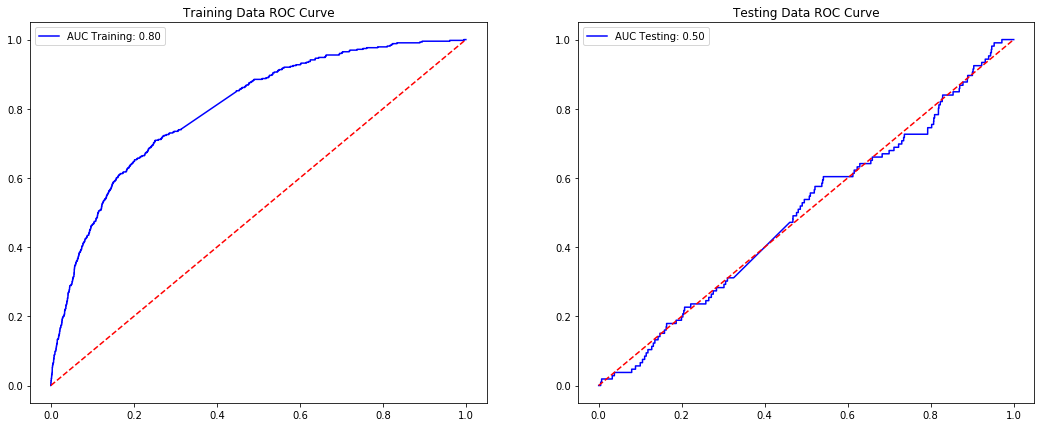

In [144]:
prediction_tests(LogisticRegression(random_state = rs))

Timing: 70.17277431488037 s
Training Accuracy: 0.987634205243097, Training ROC: 0.5011737089201878
             precision    recall  f1-score   support

          0       0.99      1.00      0.99     33943
          1       1.00      0.00      0.00       426

avg / total       0.99      0.99      0.98     34369

Testing Accuracy: 0.9874316303968347, Testing ROC: 0.4998821727347708
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      8487
          1       0.00      0.00      0.00       106

avg / total       0.98      0.99      0.98      8593



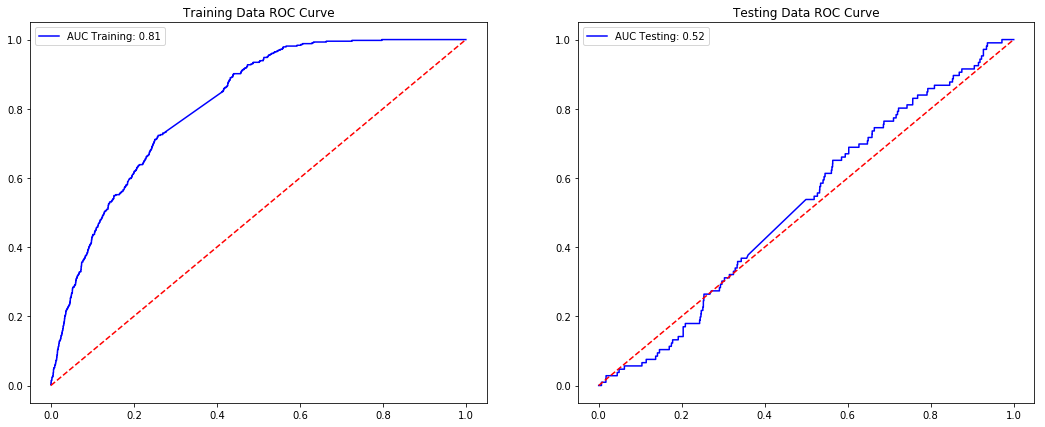

In [145]:
prediction_tests(AdaBoostClassifier(random_state = rs))

Timing: 108.29686117172241 s
Training Accuracy: 0.9927841950595013, Training ROC: 0.7100791661358817
             precision    recall  f1-score   support

          0       0.99      1.00      1.00     33943
          1       0.99      0.42      0.59       426

avg / total       0.99      0.99      0.99     34369

Testing Accuracy: 0.9821948097288491, Testing ROC: 0.4972310592671144
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      8487
          1       0.00      0.00      0.00       106

avg / total       0.98      0.98      0.98      8593



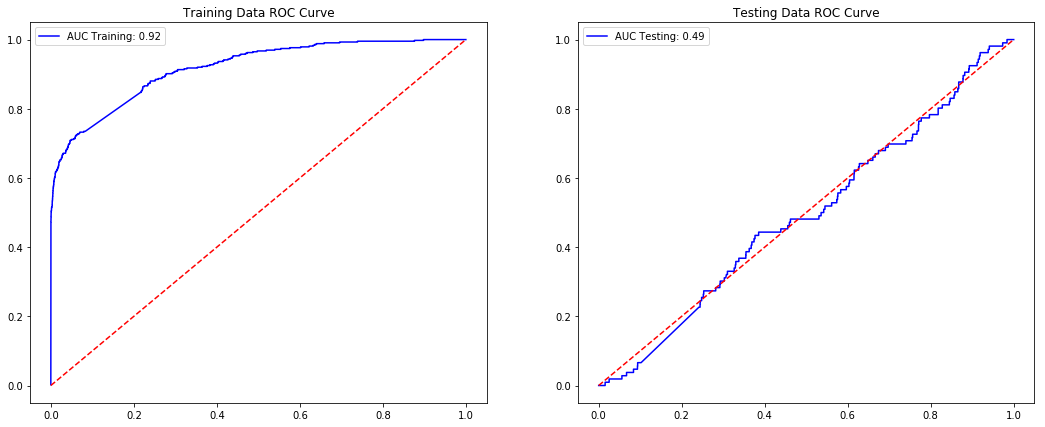

In [146]:
prediction_tests(GradientBoostingClassifier(random_state=rs))

Timing: 16.572309970855713 s
Training Accuracy: 0.9955483138875149, Training ROC: 0.8204225352112676
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     33943
          1       1.00      0.64      0.78       426

avg / total       1.00      1.00      1.00     34369

Testing Accuracy: 0.9876643779820784, Testing ROC: 0.5
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      8487
          1       0.00      0.00      0.00       106

avg / total       0.98      0.99      0.98      8593



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


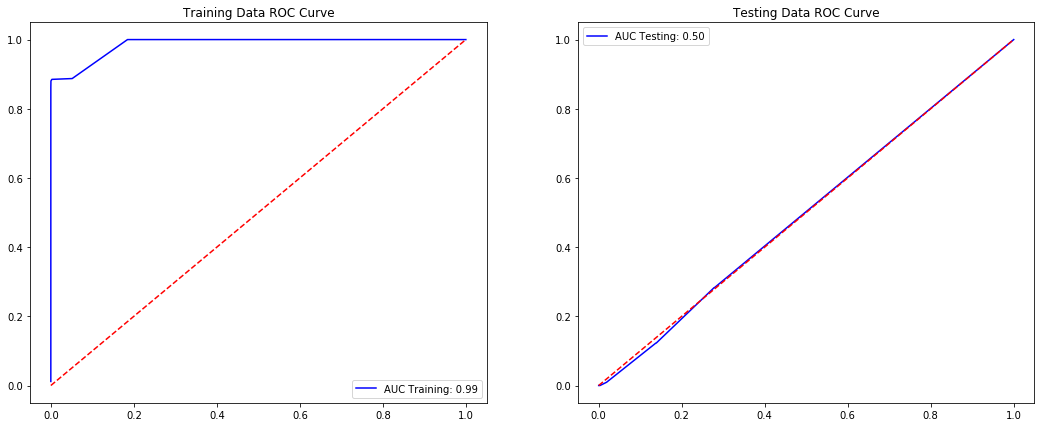

In [147]:
prediction_tests(RandomForestClassifier(random_state=rs))

In [148]:
alg_lgr = LogisticRegression(random_state = rs)
alg_abc = AdaBoostClassifier(random_state=rs)
alg_gbc = GradientBoostingClassifier(random_state=rs)
alg_rfc = RandomForestClassifier(random_state=rs)

result_list = []
for alg in [alg_lgr, alg_abc, alg_gbc, alg_rfc]:
    alg_name = alg.__class__.__name__
    
    j=0
    for train_index, val_index in skf.split(df_mailout_train, y):
    
        j+=1
        result = {}  
        result['algorithm_name'] = alg_name
        result['fold']  =  j
        # Split the data into training and test sets
        X_train, X_val = df_mailout_train.iloc[train_index], df_mailout_train.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        result['roc'] = train_predict(alg, X_train, y_train, X_val, y_val)
        result_list.append(result)
        print (result)  

print('result_list: ', result_list)

{'algorithm_name': 'LogisticRegression', 'fold': 1, 'roc': 0.49996464932126694}
{'algorithm_name': 'LogisticRegression', 'fold': 2, 'roc': 0.5}
{'algorithm_name': 'LogisticRegression', 'fold': 3, 'roc': 0.5}
{'algorithm_name': 'AdaBoostClassifier', 'fold': 1, 'roc': 0.5}
{'algorithm_name': 'AdaBoostClassifier', 'fold': 2, 'roc': 0.5}
{'algorithm_name': 'AdaBoostClassifier', 'fold': 3, 'roc': 0.5}
{'algorithm_name': 'GradientBoostingClassifier', 'fold': 1, 'roc': 0.49992929864253394}
{'algorithm_name': 'GradientBoostingClassifier', 'fold': 2, 'roc': 0.50243597379630422}
{'algorithm_name': 'GradientBoostingClassifier', 'fold': 3, 'roc': 0.49985858728699711}
{'algorithm_name': 'RandomForestClassifier', 'fold': 1, 'roc': 0.5}
{'algorithm_name': 'RandomForestClassifier', 'fold': 2, 'roc': 0.49996464682174929}
{'algorithm_name': 'RandomForestClassifier', 'fold': 3, 'roc': 0.5}
result_list:  [{'algorithm_name': 'LogisticRegression', 'fold': 1, 'roc': 0.49996464932126694}, {'algorithm_name': '

In [149]:
df_scores = pd.DataFrame(result_list)

In [150]:
df_scores

,algorithm_name,fold,roc
0,LogisticRegression,1,0.499965
1,LogisticRegression,2,0.500000
2,LogisticRegression,3,0.500000
3,AdaBoostClassifier,1,0.500000
4,AdaBoostClassifier,2,0.500000
5,AdaBoostClassifier,3,0.500000
6,GradientBoostingClassifier,1,0.499929
7,GradientBoostingClassifier,2,0.502436
8,GradientBoostingClassifier,3,0.499859
9,RandomForestClassifier,1,0.500000


In [151]:
df_scores.groupby('algorithm_name')['roc'].mean().sort_values()

algorithm_name
RandomForestClassifier        0.499988
LogisticRegression            0.499988
AdaBoostClassifier            0.500000
GradientBoostingClassifier    0.500741
Name: roc, dtype: float64

- Based on the classification reports above, all of the four algorithms display a precision or recall scores of 0 for RESPONSE = 1 in contrast to scores near 1 for RESPONSE = 0 in the testing data.


- The AdaBoost Classifier and Gradient Boosting Classifier on the other hand show better performance. They demonstrate a decrease of model bias with increasing sample size.


- Since the data is extremely unbalanced, it is hard for any algorithm to distinguish between a positive or negative response from a customer.


- The testing data ROC scores of 0.5 suggest that they can perfectly predict RESPONSE = 0 but not RESPONSE = 1. In this way, a good way to approach to make this data somewhat balanced is using an over-sampling technique such as SMOTE. 

### Gradient Boosting Classifier tunning

In [152]:
grid = dict()
grid['n_estimators'] = [50, 100]
grid['learning_rate'] = [0.2, 0.5]

In [169]:
# Define the evaluation procedure
#cv = RepeatedStratifiedKFold(n_splits=2, shuffle=True, random_state=1)

# Define the grid search procedure
grid_search = GridSearchCV(estimator=alg_abc, param_grid=grid, n_jobs=-1, scoring='roc_auc')

# Execute the grid search
grid_result = grid_search.fit(X_train, y_train)

In [170]:
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.767088 using {'learning_rate': 0.2, 'n_estimators': 50}
0.767088 (0.001038) with: {'learning_rate': 0.2, 'n_estimators': 50}
0.761362 (0.009618) with: {'learning_rate': 0.2, 'n_estimators': 100}
0.763288 (0.009510) with: {'learning_rate': 0.5, 'n_estimators': 50}
0.754448 (0.009978) with: {'learning_rate': 0.5, 'n_estimators': 100}


In [171]:
# Get the estimator and predict
best_clf = grid_result.best_estimator_
#predictions = (best_clf.fit(X_train, y_train)).predict(X_test)

best_predictions = best_clf.predict(X_test)

In [172]:
print("Final ROC score: {:.4f}".format(roc_auc_score(y_test, best_predictions)))

Final ROC score: 0.5000


### Model interpretation

Among the features that the classifier uses to predict customer response, D19_SOZIALES is by far the most important one. Unfortunately, the attribute is not described by the accompanying data guide.

In [220]:
feat_importance = best_clf.feature_importances_

['D19_SOZIALES' 'EINGEZOGENAM_HH_JAHR' 'KBA05_CCM1' 'KBA13_CCM_2500'
 'KBA05_HERST3']
[ 0.52  0.06  0.04  0.04  0.04]


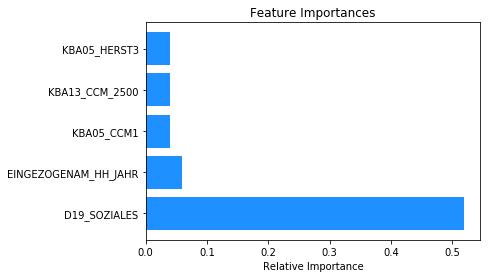

In [222]:
num_feat = 5

indices = np.argsort(feat_importance)[::-1]
columns = X_train.columns.values[indices[:num_feat]]
values = feat_importance[indices][:num_feat]

#print((indices))
print(columns)
print(values)

plt.title('Feature Importances')
plt.barh(np.arange(num_feat), values, color='dodgerblue', align='center', label = "Feature Weight")
#plt.barh(np.arange(num_feat), np.cumsum(values), color='b', align='center',label = "Cumsum Weight")


plt.yticks(np.arange(num_feat), columns)
plt.xlabel('Relative Importance')
plt.show()

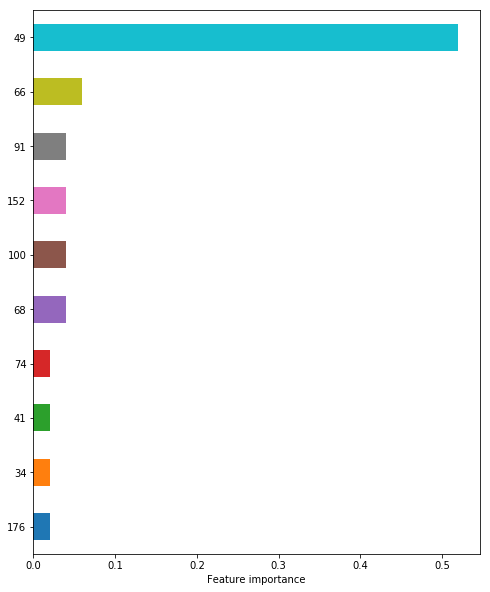

In [218]:
feature_importances = best_clf.feature_importances_
pd.Series(feature_importances).sort_values()[-10:].plot(kind='barh', figsize=(8,10))
plt.xlabel('Feature importance');

Looking at the distribution of the D19_SOZIALES attribute in our focus clusters, we see a clear characteristic in these groups:

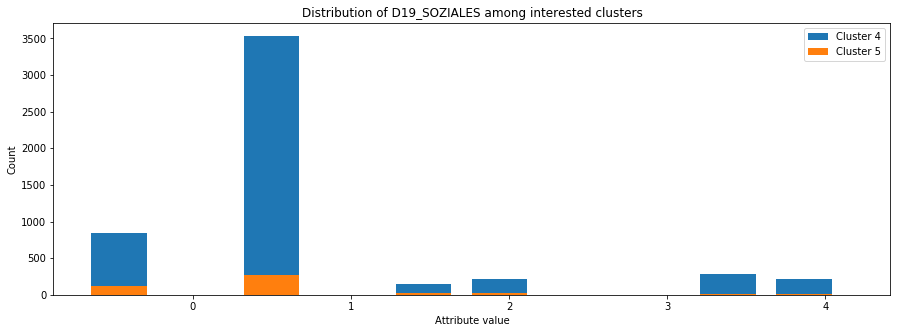

In [176]:
# Plot D19_SOZIALES distribution in relevant clusters
x1=customers.iloc[customers_clustered[customers_clustered['Cluster'] == 4].index]['D19_SOZIALES']
x2=customers.iloc[customers_clustered[customers_clustered['Cluster'] == 5].index]['D19_SOZIALES']

fig, ax = plt.subplots(figsize=(15,5))

width = 0.35 

p1 = plt.hist(x1, width=width, label='Cluster 4')
p2 = plt.hist(x2, width=width, label='Cluster 5')

plt.title('Distribution of D19_SOZIALES among interested clusters')
plt.ylabel('Count')
plt.xlabel('Attribute value')
plt.legend();

From quick comparison of above chart, we can see drastic difference in the distribution of the most important feature "D19_SOZIALES". In Cluster 5 the over represented cluster of customer, there is a single bar and in Cluster 10 under represented cluster of customer there is a distribution and not a consolidation in 1 particular value.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [177]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [178]:
print('The number of rows and columns in the df mailout test dataset are: {} and {}'.format(mailout_test.shape[0],mailout_test.shape[1]))

The number of rows and columns in the df mailout test dataset are: 42833 and 366


In [179]:
# Checking this dataset is not different
missing = list(np.setdiff1d(mailout_train.columns, mailout_test.columns))
missing

['RESPONSE']

In [180]:
print('Before preprocessing mailout_test.shape: ', mailout_test.shape)
mailout_test_clean = data_preprocess(mailout_test, False)
print('After preprocessing mailout_test_clean.shape: ', mailout_test_clean.shape)

Before preprocessing mailout_test.shape:  (42833, 366)
Shape of dataframe after correlation analysis (42833, 253)
Shape of dataframe after One Hot Encoding (42833, 300)
Shape of dataframe after impute (42833, 300)
Shape of dataframe after scaling (42833, 300)
After preprocessing mailout_test_clean.shape:  (42833, 299)


In [181]:
kaggle_competition = best_clf.predict(mailout_test_clean)

In [182]:
df_kaggle = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=kaggle_competition)
df_kaggle.rename(columns={0: "RESPONSE"}, inplace=True)

In [183]:
df_kaggle.sample(15)

,RESPONSE
LNR,
58198,0
45667,0
633,0
24773,0
49503,0
73049,0
82697,0
2609,0
9890,0


In [184]:
df_kaggle.to_csv('kaggle_submission.csv', index=False)

In [186]:
print("Hello world")

Hello world
